In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['animation.ffmpeg_path'] = 'C:/Program Files/ffmpeg/bin/ffmpeg.exe'
# import time
# from celluloid import Camera
# from IPython.display import HTML

In [2]:
def updateQP(oldQ, oldP, masses):
    numObjs = len(masses)
    newQ = oldQ
    newP = oldP
    for i in range(numObjs):
        deltaP = [0.0, 0.0, 0.0]
        for j in range(numObjs):
            if (j != i):
                interObjDir = oldQ[j] - oldQ[i]
                interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
                deltaP += (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
                
        newP[i] += deltaP
        newQ[i] += oldP[i] / masses[i]
    
    return newQ, newP

<IPython.core.display.Javascript object>


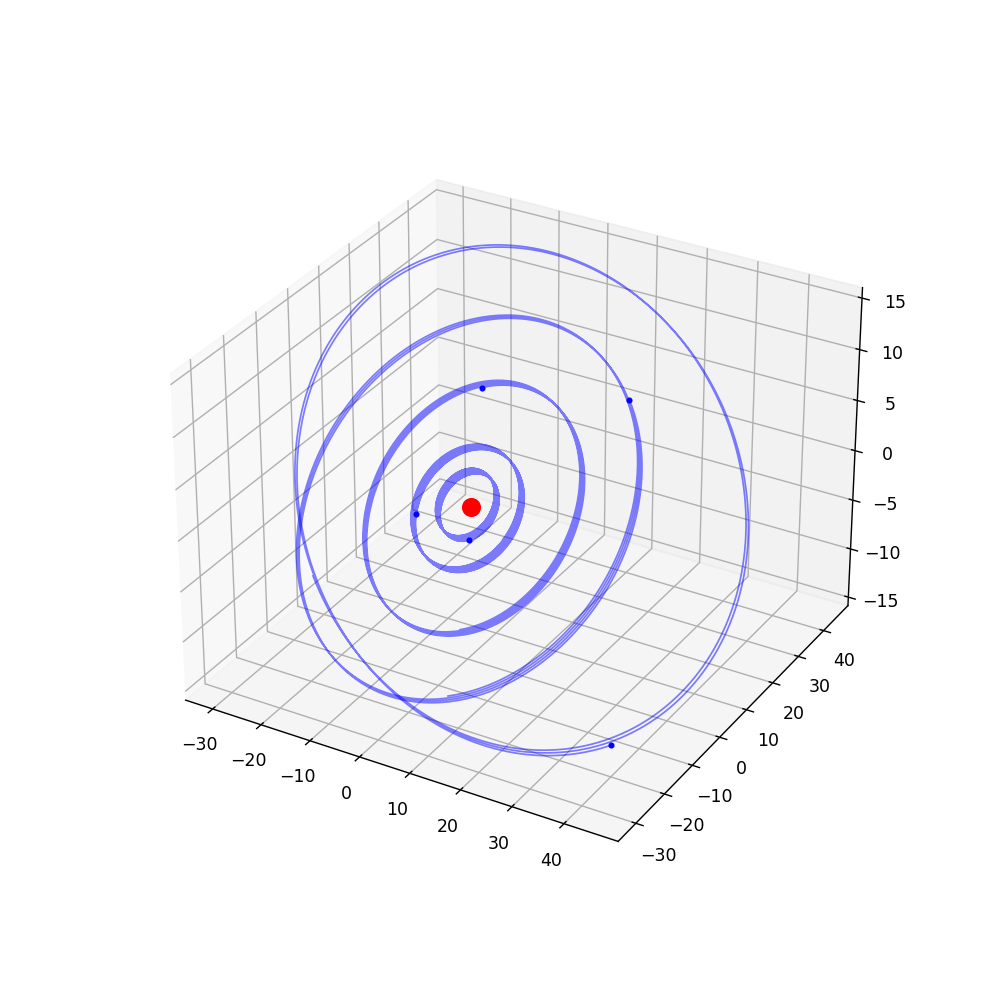

In [3]:
numberTimeSteps = 200000
# storedTimeSteps = 200
# storeFreq = 10
# frameFreq = 500
updateFn = updateQP

names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
numObjs = len(names)
masses = [1.00000597682, 9.54786104043e-4, 2.85583733151e-4, 4.37273164546e-5, 5.17759138449e-5, 1/(1.3e8)]
q = np.array(
    [[0,0,0],
    [-3.5023653,-3.8169847,-1.5507963],
    [9.0755314,-3.0458353,-1.6483708],
    [8.3101420, -16.2901086, -7.2521278],
    [11.4707666, -25.7294829, -10.8169456],
    [-15.5387357, -25.2225594, -3.1902382]])
v = np.array(
    [[0,0,0],
    [0.00565429, -0.00412490, -0.0019058],
    [0.00168318, 0.00483525, 0.00192462],
    [0.00354178, 0.00137102, 0.00055029],
    [0.00288930, 0.00114527, 0.00039677],
    [0.00276725, -0.00170702, -0.00136504]])
p = np.array([(masses[i]*v[i]).tolist() for i in range(numObjs)])

qStored = np.empty((numberTimeSteps,numObjs,3))
qStored[:] = np.nan

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(projection='3d')
# camera = Camera(fig)

for i in range(numberTimeSteps):
    
    oldQ = q
    oldP = p
    # TODO
    newQ, newP = updateQP(oldQ, oldP, masses)
    # TODO
    q = newQ
    p = newP
    if ((i+1)%int(numberTimeSteps/100) == 0):
        print("{}% has been completed".format((i+1)*100/numberTimeSteps), end = "\r")
        
#     if (i%storeFreq == 0):
#         index = ((index + 1) % storedTimeSteps)
    qStored[i] = newQ
        
#     if (i%frameFreq == 0):
#         ax = fig.gca()
#         ax.plot(newQ[0][0], newQ[0][1], newQ[0][2], color = 'red', marker = 'o', markersize=10)
#         for j in range(1, numObjs):
#             ax.plot(newQ[j][0], newQ[j][1], newQ[j][2], color = 'blue', marker = '.', markersize=5)
    
#         reorderQ = np.append(qStored[index+1:storedTimeSteps], qStored[0:index+1], axis=0)
#         ax.plot(reorderQ[:,0,0], reorderQ[:,0,1], reorderQ[:,0,2], color = 'red', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
#         for j in range(1, numObjs):
#             ax.plot(reorderQ[:,j,0], reorderQ[:,j,1], reorderQ[:,j,2], color = 'blue', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
    
#         camera.snap()
    
# animation = camera.animate(interval = 15)
# HTML(animation.to_html5_video())

ax = fig.gca()
ax.plot(qStored[-1][0][0], qStored[-1][0][1], qStored[-1][0][2], color = 'red', marker = 'o', markersize=10)
for j in range(1, numObjs):
    ax.plot(qStored[-1][j][0], qStored[-1][j][1], qStored[-1][j][2], color = 'blue', marker = '.', markersize=5)

ax.plot(qStored[:,0,0], qStored[:,0,1], qStored[:,0,2], color = 'red', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
for j in range(1, numObjs):
    ax.plot(qStored[:,j,0], qStored[:,j,1], qStored[:,j,2], color = 'blue', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)

plt.savefig('Orbits.svg', dpi=2400)